# Cross Validation

The purpose of this section is to investigate whether (and how well) cross validation can recover the true sparsity parameter $k$. We tested normal, logistic, and poisson cross validation results using 5 fold cross validation across 20 different model sizes $k \in \{1,2,...,20\}$ where $k_{true} = 10$. Since the purpose is on validating cross validation and not to test scalability, we ran code on 5000 samples and 100000 SNPs.

In [1]:
versioninfo()

Julia Version 1.0.3
Commit 099e826241 (2018-12-18 01:34 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-3740QM CPU @ 2.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.0 (ORCJIT, ivybridge)


In [2]:
# using StatsPlots
using DelimitedFiles
using Statistics
using Plots
using PyPlot
using Gadfly
using DataFrames
using Cairo
using Fontconfig
axisfont = Plots.font("Helvetica", 16)
ticfont = Plots.font("Helvetica", 12)
pyplot(guidefont=axisfont, xtickfont=ticfont, ytickfont=ticfont, legendfont=axisfont)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/biona001/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
Fontconfig warning: ignoring UTF-8: not a valid region tag


Plots.PyPlotBackend()

# Import data

In [3]:
models = collect(1:20)

normal_cv_drs       = readdlm("normal_cv_drs") #drs stands for deviance residuals = MSEs
normal_cv_memory    = readdlm("normal_cv_memory")
normal_cv_run_times = readdlm("normal_cv_run_times")

normal_cv_drs_nodebias       = readdlm("normal_nodebias_cv_drs")
normal_cv_memory_nodebias    = readdlm("normal_nodebias_cv_memory")
normal_cv_run_times_nodebias = readdlm("normal_nodebias_cv_run_times")

logistic_cv_drs       = readdlm("logistic_cv_drs")
logistic_cv_memory    = readdlm("logistic_cv_memory")
logistic_cv_run_times = readdlm("logistic_cv_run_times")

logistic_cv_drs_nodebias       = readdlm("logistic_nodebias_cv_drs")
logistic_cv_memory_nodeibas    = readdlm("logistic_nodebias_cv_memory")
logistic_cv_run_times_nodebias = readdlm("logistic_nodebias_cv_run_times")

poisson_cv_drs       = readdlm("poisson_cv_drs")
poisson_cv_memory    = readdlm("poisson_cv_memory")
poisson_cv_run_times = readdlm("poisson_cv_run_times")

poisson_cv_drs_nodebias       = readdlm("poisson_nodebias_cv_drs")
poisson_cv_memory_nodeibas    = readdlm("poisson_nodebias_cv_memory")
poisson_cv_run_times_nodebias = readdlm("poisson_nodebias_cv_run_times")

# negativebinomial_cv_drs       = readdlm("negativebinomial_cv_drs")
# negativebinomial_cv_memory    = readdlm("negativebinomial_cv_memory")
# negativebinomial_cv_run_times = readdlm("negativebinomial_cv_run_times")

negativebinomial_cv_drs_nodebias       = readdlm("negativebinomial_nodebias_cv_drs")
negativebinomial_cv_memory_nodeibas    = readdlm("negativebinomial_nodebias_cv_memory")
negativebinomial_cv_run_times_nodebias = readdlm("negativebinomial_nodebias_cv_run_times");

# Plot mean squared errors (aka deviance residuals)

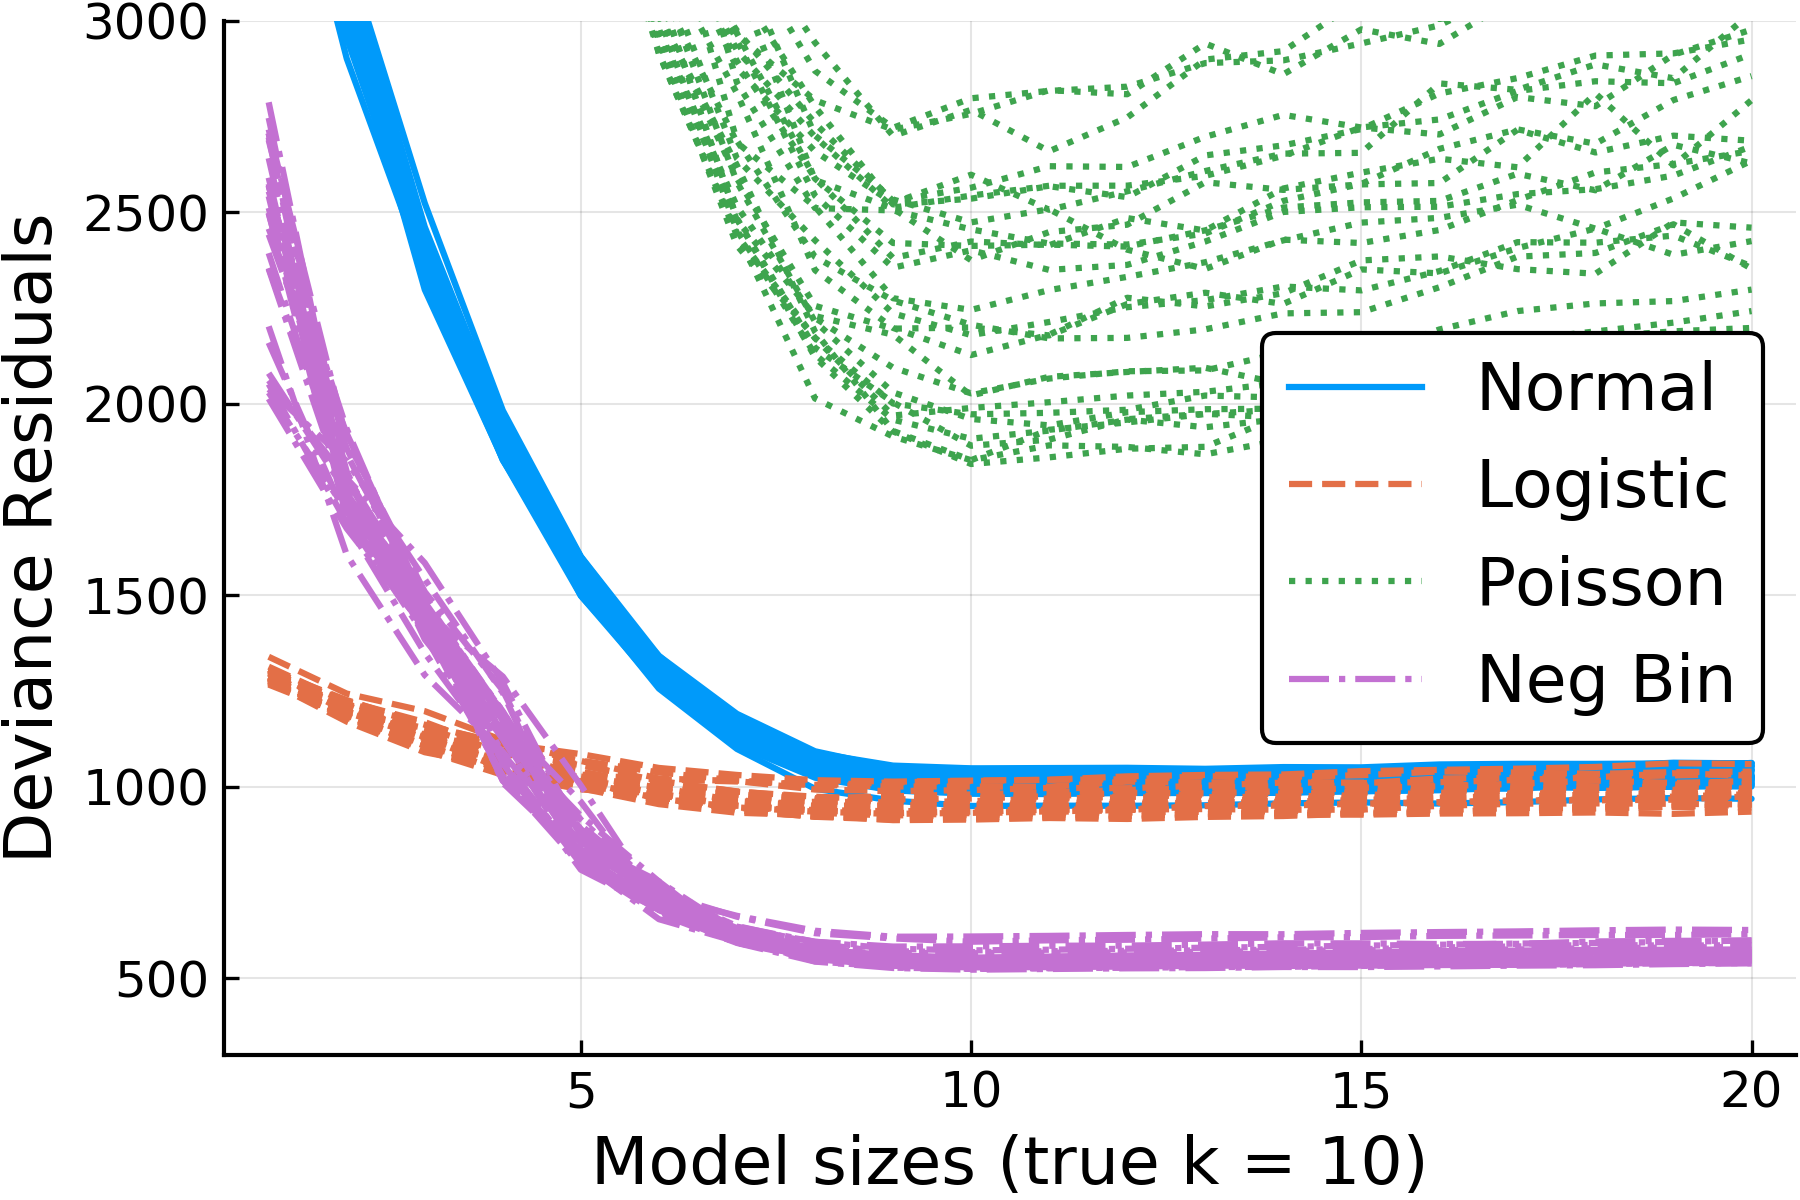

In [20]:
#default color that matches the benchmark figure
mycolors = get_color_palette(:auto, plot_color(:white), 17) 

#add only 1 label for each distribution
all_plt = Plots.plot(models, normal_cv_drs[:, 1],  ylim=(300, 3000),w=1.5,
    linestyle = [:solid], color=mycolors[1], label="Normal", dpi=300,
    ylabel = "Deviance Residuals", xlabel = "Model sizes (true k = 10)")
Plots.plot!(models, logistic_cv_drs[:, 1], linestyle = [:dash], color=mycolors[2], 
    label="Logistic", w=1.5)
Plots.plot!(models, poisson_cv_drs_nodebias[:, 1], w=1.5,
    linestyle = [:dot], color=mycolors[3], label="Poisson")
Plots.plot!(models, negativebinomial_cv_drs_nodebias[:, 1], w=1.5,
    linestyle = [:dashdot], color=mycolors[4], label="Neg Bin")

#don't add labels now
Plots.plot!(models, normal_cv_drs[:, 2:end], label="", w=1.5,
    linestyle = [:solid], color=mycolors[1],
    ylabel = "Deviance Residuals", xlabel = "Model sizes (true k = 10)")
Plots.plot!(models, logistic_cv_drs[:, 2:end], label="", 
    linestyle = [:dash], color=mycolors[2], w=1.5,
    xlabel = "Model sizes (true k = 10)", ylabel = "Deviance Residuals")
Plots.plot!(models, poisson_cv_drs_nodebias[:, 2:end], 
    ylabel = "Deviance Residuals", label="", 
    linestyle = [:dot], color=mycolors[3], w=1.5,
    xlabel = "Model sizes (true k = 10)")
Plots.plot!(models, negativebinomial_cv_drs_nodebias[:, 2:end], 
    ylabel = "Deviance Residuals", label="",w=1.5,
    linestyle = [:dashdot], color=mycolors[4],
    xlabel = "Model sizes (true k = 10)")

# Make histograms for best k

In [21]:
#histograms
best_k_normal = zeros(30)
best_k_logistic = zeros(30)
best_k_poisson = zeros(30)
best_k_negbin = zeros(30)
for i in 1:30
    best_k_normal[i] = argmin(normal_cv_drs[:, i])
    best_k_logistic[i] = argmin(logistic_cv_drs[:, i])
    best_k_poisson[i] = argmin(poisson_cv_drs_nodebias[:, i])
    best_k_negbin[i] = argmin(negativebinomial_cv_drs_nodebias[:, i])
end

@show median(best_k_normal)
@show median(best_k_negbin)
@show median(best_k_poisson)
@show median(best_k_logistic)

median(best_k_normal) = 11.0
median(best_k_negbin) = 10.0
median(best_k_poisson) = 10.0
median(best_k_logistic) = 9.0


9.0

In [22]:
my_df = DataFrame(Distribution=String[],Best_k=Int64[])
for i in 1:30
    push!(my_df, ["Normal" best_k_normal[i]])
    push!(my_df, ["Logistic" best_k_logistic[i]])
    push!(my_df, ["Poisson" best_k_poisson[i]])
    push!(my_df, ["Neg Bin" best_k_negbin[i]])
end

In [23]:
#need to open the figure to see this? I didn't have to before wtf
bar = Gadfly.plot(my_df, x="Best_k", color="Distribution", Geom.histogram(), 
    Guide.xticks(ticks=[5:2:15;]), Guide.xlabel("Best k Estimate"), 
    Guide.ylabel("Counts"),Theme(background_color=colorant"white"))

Plot(...)

In [24]:
Gadfly.draw(PNG("all_bar.png", dpi=300), bar)

In [25]:
Plots.savefig(all_plt, "all_drs.png")